<a href="https://colab.research.google.com/github/Hamza1122/Store-Item-Demand-Forecasting-Challenge/blob/master/My_First_Time_Series_Comp_(Added_Prophet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary Imports

In [73]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
#from google.colab import files
#uploaded=files.upload()

In [75]:
import time

import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

import statsmodels.api as sm

init_notebook_mode(connected=True)
#def mean_absolute_percentage_error(y_true, y_pred): 
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [0]:
# print(os.listdir(PATH))

In [0]:
train = pd.read_csv('train.csv',parse_dates=['date'])
test = pd.read_csv('test.csv',parse_dates=['date'], index_col=['date'])
result = pd.read_csv('sample_submission.csv')

In [78]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [0]:
def excluding_function(train):
  train['monthly_day']=train.date.dt.day
  train['monthly']=train.date.dt.month
  train['yearly']=train.date.dt.year
  train['monthly_day']=train.date.dt.dayofweek
  
  return train

In [0]:
train=excluding_function(train)



#df_raw['item'].unique()


In [81]:
train.head(4)
#print("Train and Test shape are {} and {} respectively".format(df_raw.shape, df_test.shape))

,date,store,item,sales,monthly_day,monthly,yearly
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,2,1,2013
2,2013-01-03,1,1,14,3,1,2013
3,2013-01-04,1,1,13,4,1,2013


In [82]:
test.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


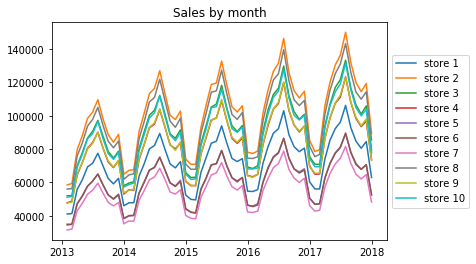

In [83]:
import matplotlib.pyplot as plt

for i in range(1,11):
    month_summary = train[train.store==i].resample('M',on='date').sum()
    label_x= np.array(month_summary.index)
    label_y=np.array(month_summary.sales)
    plt.plot(label_x,label_y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Sales by month")
plt.show()

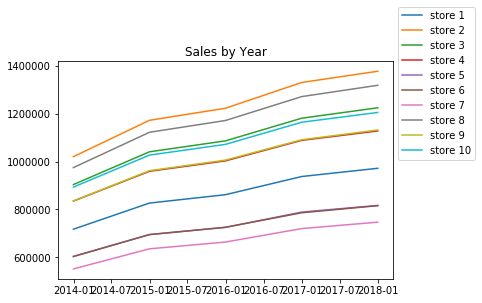

In [84]:
import matplotlib.pyplot as plt

for i in range(1,11):
    month_summary = train[train.store==i].resample('Y',on='date').sum()
    label_x= np.array(month_summary.index)
    label_y=np.array(month_summary.sales)
    plt.plot(label_x,label_y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1,0.9))
plt.title("Sales by Year")
plt.show()

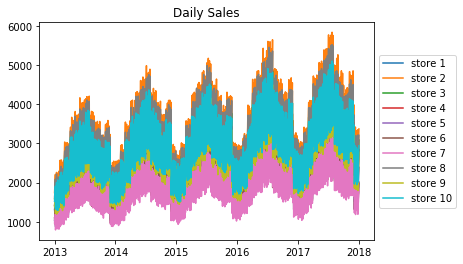

In [85]:
import matplotlib.pyplot as plt

for i in range(1,11):
    month_summary = train[train.store==i].resample('D',on='date').sum()
    label_x= np.array(month_summary.index)
    label_y=np.array(month_summary.sales)
    plt.plot(label_x,label_y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily Sales")
plt.show()

In [86]:
train.head(4)

,date,store,item,sales,monthly_day,monthly,yearly
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,2,1,2013
2,2013-01-03,1,1,14,3,1,2013
3,2013-01-04,1,1,13,4,1,2013


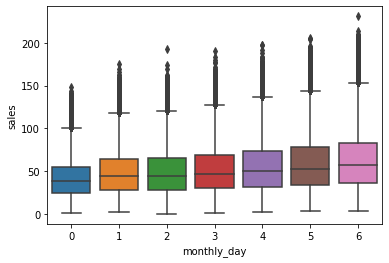

In [87]:
sns.boxplot(x="monthly_day", y="sales", data=train)

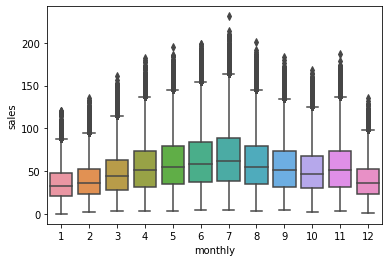

In [88]:
sns.boxplot(x="monthly", y="sales", data=train)

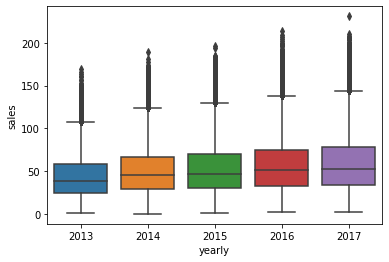

In [89]:
sns.boxplot(x="yearly", y="sales", data=train)

In [0]:
train=train.set_index('date')

In [91]:
sampling_variable = train['sales'].resample('MS').mean() 
sampling_variable['2017':] #sneak peak


date
2017-01-01    39.826194
2017-02-01    44.383500
2017-03-01    53.075290
2017-04-01    62.590800
2017-05-01    65.850710
2017-06-01    70.974933
2017-07-01    75.573742
2017-08-01    66.219548
2017-09-01    62.350867
2017-10-01    57.494194
2017-11-01    61.922467
2017-12-01    44.849677
Freq: MS, Name: sales, dtype: float64

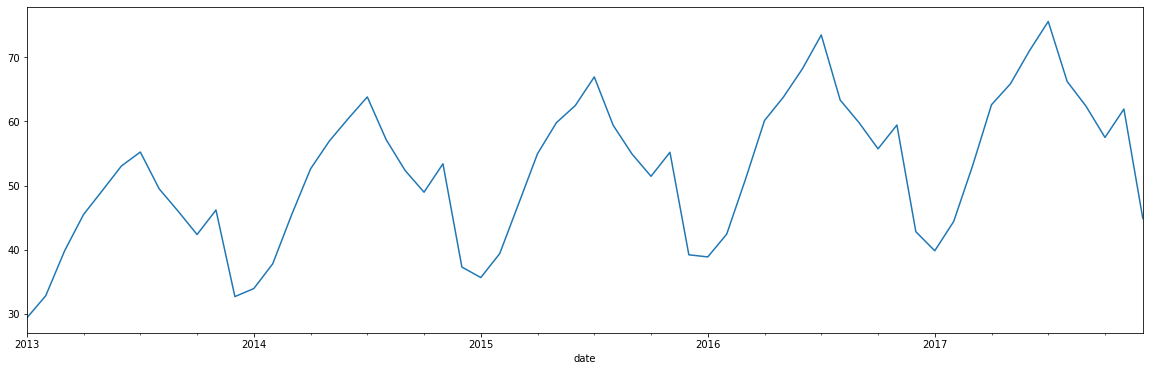

In [92]:
sampling_variable.plot(figsize=(20, 6),);


In [0]:
def additive_function(sample_variable):
  additive = sm.tsa.seasonal_decompose(sampling_variable, model='additive')
  additive.plot();

def multiplicative_function(sample_variable):
  multi = sm.tsa.seasonal_decompose(sampling_variable, model='multiplicative')
  multi.plot();

  

'Addictive'

None

'Multiplicative'

None

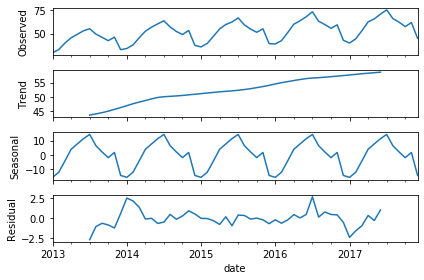

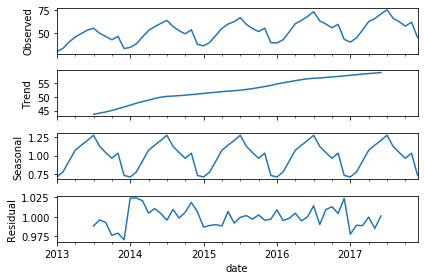

In [94]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.

#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;
display("Addictive",additive_function(sampling_variable))
display("Multiplicative",multiplicative_function(sampling_variable))




## Moving Average

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the moving average.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [95]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(train['yearly'], 24) # prediction for the last observed day (past 24 hours)

2017.0

In [96]:
train.head(3)

,store,item,sales,monthly_day,monthly,yearly
date,,,,,,
2013-01-01,1,1,13,1,1,2013
2013-01-02,1,1,11,2,1,2013
2013-01-03,1,1,14,3,1,2013


Augmented Dickey Fuller Test

In [0]:
from statsmodels.tsa.stattools import adfuller
#def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    #print ('Results of Dickey-Fuller Test:')
    #dftest = adfuller(timeseries, autolag='AIC')
    #dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   # for key,value in dftest[4].items():
  #     dfoutput['Critical Value (%s)'%key] = value
 #   print (dfoutput)

#apply adf test on the series
#adf_test(train['sales'])

In [0]:
def Rolling_Mean_Average(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(25,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
        plt.plot(lower_bond, color='Black', alpha=.3)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

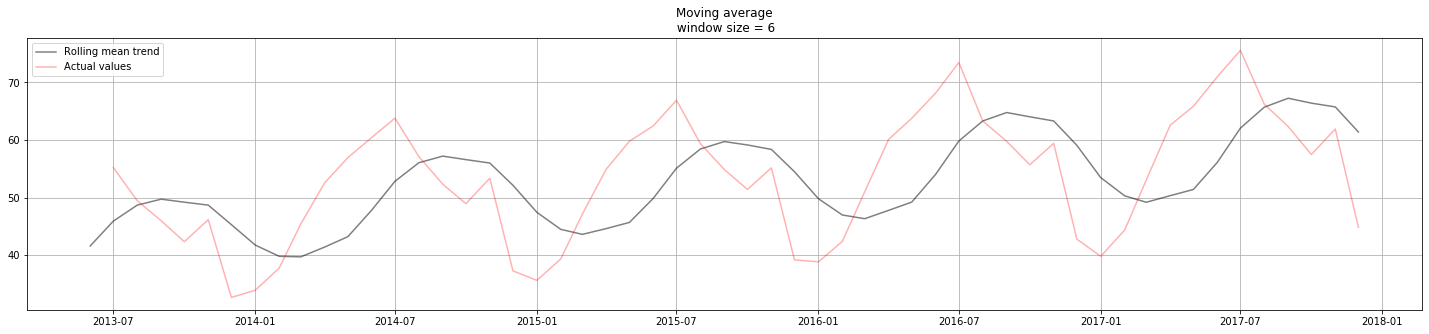

In [99]:
Rolling_Mean_Average(sampling_variable,6, plot_intervals=False, scale=2, plot_anomalies=False)

In [0]:
#Applying Normalization
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [0]:
scaler_train=train.copy()
scaler_test=test.copy()

In [0]:
from sklearn.model_selection import train_test_split
Y=scaler_train.sales.values
X=scaler_train.drop('sales',axis=1).values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.4, random_state=0)

In [111]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {'task':'train', 'boosting_type':'gbdt', 'objective':'regression', 
              'metric': {'rmse'}, 'num_leaves': 10, 'learning_rate': 0.05, 
              'feature_fraction': 0.8, 'max_depth': 5, 'verbose': 0, 
              'num_boost_round':15000, 'early_stopping_rounds':100, 'nthread':-1}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[1]	valid_0's rmse: 28.5206
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 28.1684
[3]	valid_0's rmse: 27.9686
[4]	valid_0's rmse: 27.7802
[5]	valid_0's rmse: 27.6091
[6]	valid_0's rmse: 27.2765
[7]	valid_0's rmse: 26.9835
[8]	valid_0's rmse: 26.8002
[9]	valid_0's rmse: 26.5277
[10]	valid_0's rmse: 26.271
[11]	valid_0's rmse: 26.1013
[12]	valid_0's rmse: 25.886
[13]	valid_0's rmse: 25.6972
[14]	valid_0's rmse: 25.5731
[15]	valid_0's rmse: 25.3046
[16]	valid_0's rmse: 25.1105
[17]	valid_0's rmse: 24.8602
[18]	valid_0's rmse: 24.6304
[19]	valid_0's rmse: 24.4741
[20]	valid_0's rmse: 24.3013
[21]	valid_0's rmse: 24.1086
[22]	valid_0's rmse: 23.9726
[23]	valid_0's rmse: 23.7845
[24]	valid_0's rmse: 23.6635
[25]	valid_0's rmse: 23.5421
[26]	valid_0's rmse: 23.359
[27]	valid_0's rmse: 23.232
[28]	valid_0's rmse: 23.1079
[29]	valid_0's rmse: 22.9569
[30]	valid_0's rmse: 22.8259
[31]	valid_0's rmse: 22.6946
[32]	valid_0's rmse: 22.5748
[33]	valid_0's rmse: 2

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

In [0]:

serie_size = len(train_x)
n_features = 1

In [0]:
#model = Sequential()
#model.add(GRU(32, recurrent_dropout=0.1, return_sequences=True, input_shape=(serie_size, n_features)))
#model.add(Dropout(0.3))
#$model.add(GRU(32, recurrent_dropout=0.1, input_shape=(serie_size, n_features)))
#model.add(Dropout(0.3))
#model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dense(1))

#model.summary()
#adam = optimizers.Adam(0.01)
#model.compile(loss='mae', metrics=['mse', 'msle'], optimizer=adam)

## Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [0]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [0]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(35, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual", alpha = 0.4)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

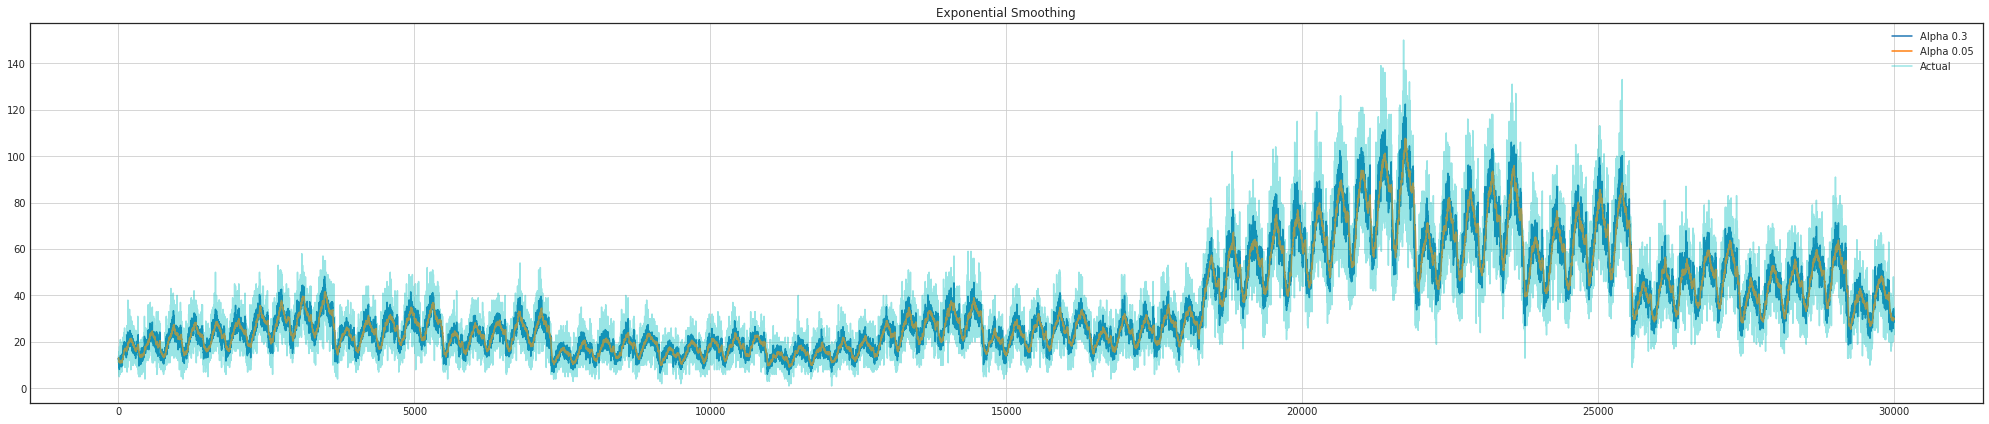

In [134]:
plotExponentialSmoothing(train.sales[:30000], [0.3, 0.05])

## Double exponential Smoothing

Up to now, the methods that we've have seen are for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

- The first one describes the intercept, which, as before, depends on the current value of the series.
- The second term is now split into previous values of the level and of the trend. 
    -  The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. 
- The final prediction is the sum of the model values of the intercept and trend.

In [0]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual", alpha = 0.1)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

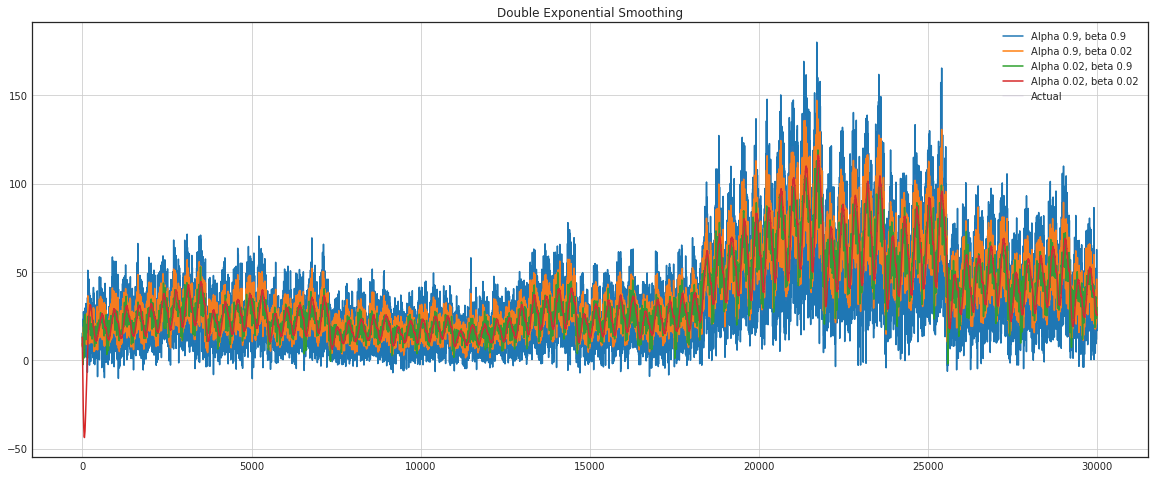

In [139]:
plotDoubleExponentialSmoothing(train.sales[:30000], alphas=[0.9, 0.02], betas=[0.9, 0.02])

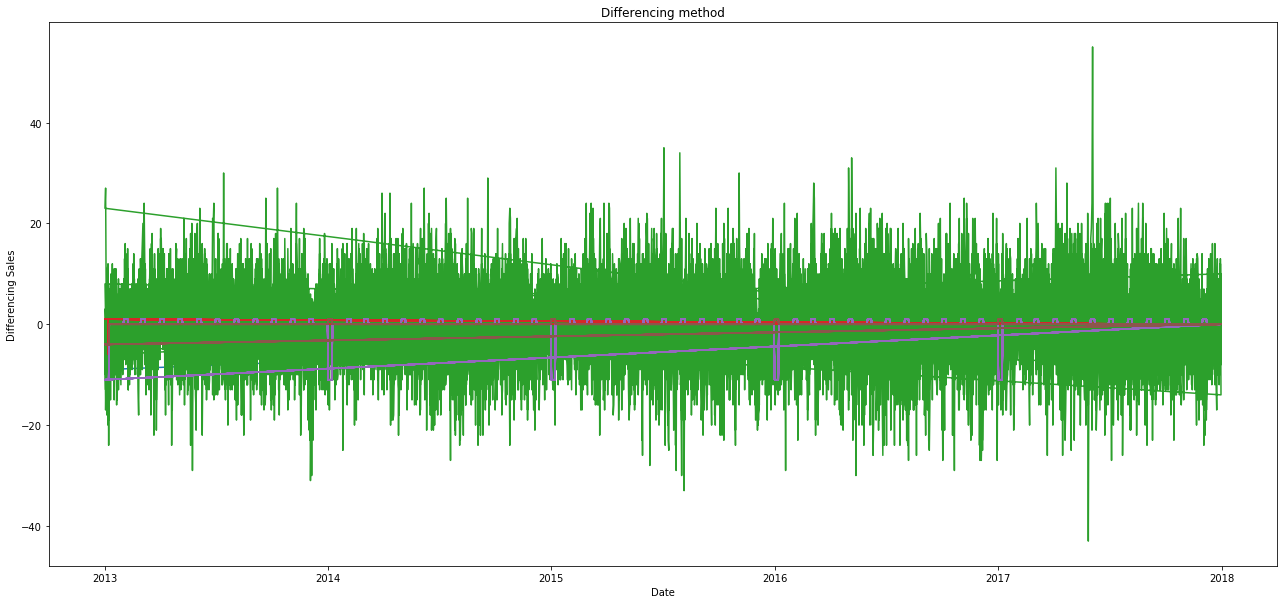

In [140]:
ts_diff = train - train.shift(7)
plt.figure(figsize=(22,10))
plt.plot(ts_diff[:20000])
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Sales");

In [0]:
df_raw = train.reset_index()
df_test = test.reset_index()

In [0]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'date',False)
add_datepart(df_test,'date',False)

##  Few Pivoted Plots

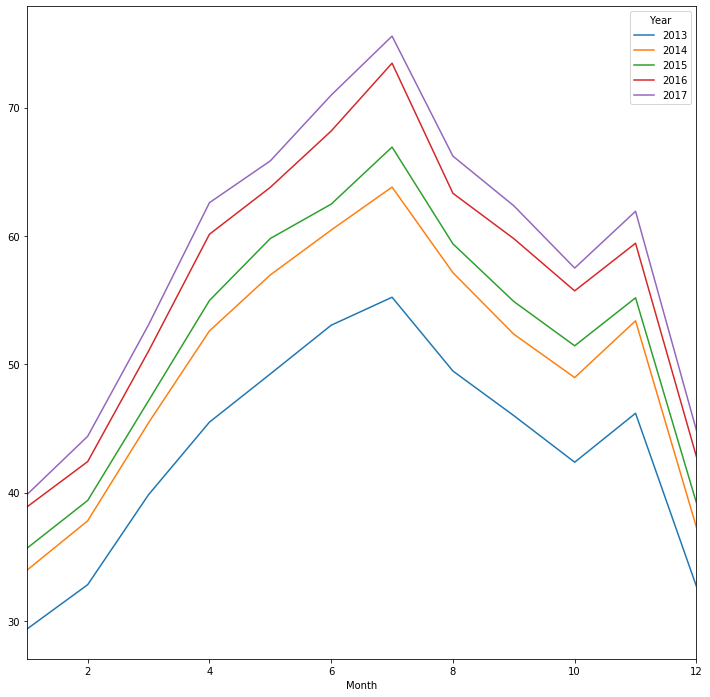

In [144]:
pivoted = pd.pivot_table(df_raw, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

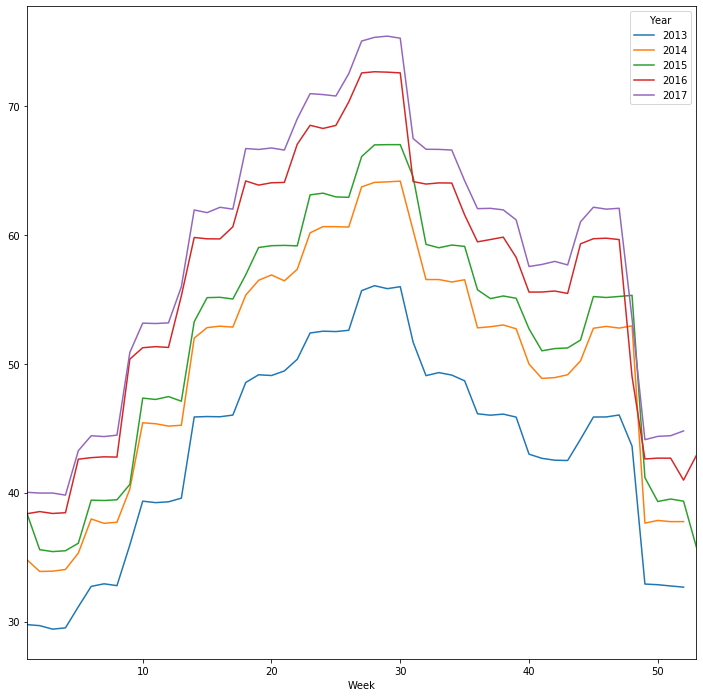

In [145]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

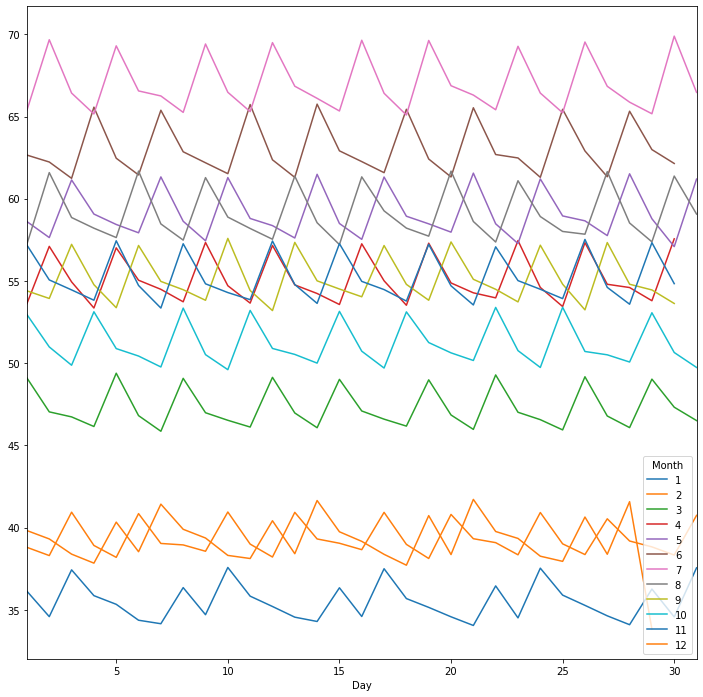

In [146]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

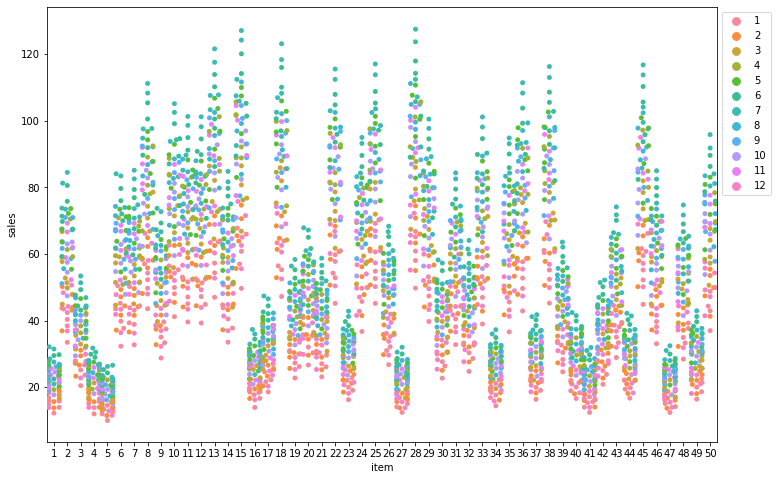

In [147]:
temp_1 = df_raw.groupby(['Year','Month','item'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8))
sns.swarmplot('item', 'sales', data=temp_1, hue = 'Month');
# Place legend to the right
plt.legend(bbox_to_anchor=(1, 1), loc=2);

In [0]:
#In case the above plot is clutterd(which it is), try this, (Will create a grid for Year vs Month)
#sns.factorplot('item', 'sales', data=temp_1, hue = 'Month', col='Year',row='Month', kind='swarm', size = 5);

<Figure size 864x576 with 0 Axes>

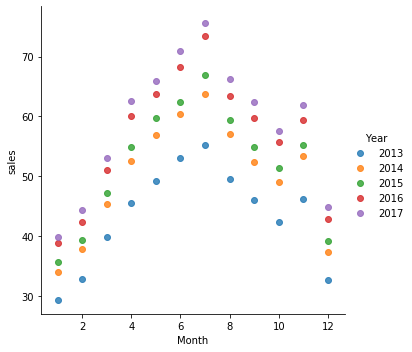

In [149]:
temp_1 = df_raw.groupby(['Year','Month'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.lmplot('Month','sales',data = temp_1, hue='Year', fit_reg= False);

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 864x576 with 0 Axes>

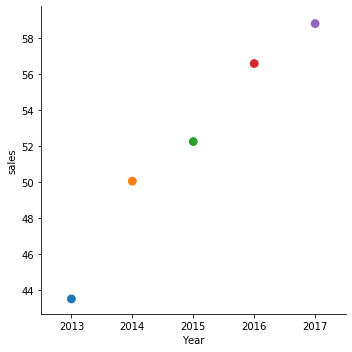

In [150]:
temp_1 = df_raw.groupby(['Year'])['sales'].mean().reset_index()
plt.figure(figsize=(12,8));
sns.factorplot('Year','sales',data = temp_1, hue='Year', kind='point');

In [0]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [152]:
original_target = df_raw.sales.values
target, lambda_prophet = stats.boxcox(df_raw['sales'] + 1)
len_train=target.shape[0]
merged_df = pd.concat([df_raw, df_test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




##  ARIMA

**We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.**

**ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data..**

- AR: Auto-Regressive (p): AR terms are just lags of dependent variable. For example lets say p is 3, we will use x(t-1), x(t-2) and x(t-3) to predict x(t)
- I: Integrated (d): These are the number of nonseasonal differences. For example, in our case we take the first order difference. So we pass that variable and put d=0
- MA: Moving Averages (q): MA terms are lagged forecast errors in prediction equation.

In [0]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [0]:
# figure for subplots
plt.figure(figsize = (12, 8))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)
#these plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

**From the above we cn see that the lags till 50 are having weightage wrt the ACF Plots, but according to the PACF plots they valley out after the 10th lag...**

In [0]:
cnt = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            cnt += 1
            if cnt % 50 :
                print('Current Iter - {}, ARIMA{}x{} 12 - AIC:{}'.format(cnt, param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that SARIMA(2, 0, 1)x(2, 2, 0, 12) yields the lowest AIC value of 17.435499462373613. Therefore we should consider this to be optimal option.
- ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:28.152584128715233
- ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:21.20352160942468
- ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:18.308712222027623
- ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:18.039431593093965
- ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:17.583895110587616
- ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:17.435499462373613
- ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:17.473412955915293

In [0]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 1),
                                seasonal_order=(2, 2, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [0]:
## Validating Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [0]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#The MSE is a measure of the quality of an estimator — it is always non-negative, 
#and the smaller the MSE, the closer we are to finding the line of best fit.

In [0]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

In [0]:
subs.head()